### Import Packages

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

from funcs import load_stocks_dataframe

In [46]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf

In [2]:
df = load_stocks_dataframe()
df = df.dropna()

In [3]:
df.head()

,Date,GrowthStock_AdjClose,GrowthStock_PercentChange,ValueStock_AdjClose,ValueStock_PercentChange,Treasury10yr_AdjClose,Treasury10yr_PercentChange,Treasury10yr_Diff,exchange,exchange_PercentChange,exchange_Diff,inflation5yr,inflation5yr_PercentChange,inflation5yr_Diff,CPI,CPI_PercentChange,CPI_Diff
712,2003-04-01,8.603225,0.010614,26.337534,0.016642,3.827,0.001046,0.004,1.4729,0.002314,0.0034,1.64,-0.006061,-0.01,2.17513,-0.034786,-0.07839
713,2003-04-02,8.835845,0.027039,27.103275,0.029074,3.932,0.027437,0.105,1.4762,0.002240,0.0033,1.66,0.012195,0.02,2.17513,-0.034786,-0.07839
714,2003-04-03,8.831999,-0.000435,26.878065,-0.008309,3.916,-0.004069,-0.016,1.4760,-0.000135,-0.0002,1.64,-0.012048,-0.02,2.17513,-0.034786,-0.07839
715,2003-04-04,8.824308,-0.000871,27.038921,0.005985,3.944,0.007150,0.028,1.4720,-0.002710,-0.0040,1.63,-0.006098,-0.01,2.17513,-0.034786,-0.07839
716,2003-04-07,8.828156,0.000436,27.109701,0.002618,4.014,0.017748,0.070,1.4843,0.008356,0.0123,1.61,-0.012270,-0.02,2.17513,-0.034786,-0.07839


### Running on Growth Stocks

In [49]:
growth_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "Treasury10yr_PercentChange": df[["Treasury10yr_PercentChange"]],
            "inflation5yr_PercentChange": df[["inflation5yr_PercentChange"]],
            "CPI_PercentChange"         : df[["CPI_PercentChange"]],
            "exchange_PercentChange"    : df[["exchange_PercentChange"]]
        },
        {
            "GrowthStock_PercentChange" : df[["GrowthStock_PercentChange"]]
        }
    )
)

len(growth_dataset)

3696

In [50]:
growth_dataset.take

<bound method DatasetV2.take of <TensorSliceDataset element_spec=({'Treasury10yr_PercentChange': TensorSpec(shape=(1,), dtype=tf.float64, name=None), 'inflation5yr_PercentChange': TensorSpec(shape=(1,), dtype=tf.float64, name=None), 'CPI_PercentChange': TensorSpec(shape=(1,), dtype=tf.float64, name=None), 'exchange_PercentChange': TensorSpec(shape=(1,), dtype=tf.float64, name=None)}, {'GrowthStock_PercentChange': TensorSpec(shape=(1,), dtype=tf.float64, name=None)})>>

In [51]:
# train, test split
train_size = int(0.7*(len(growth_dataset)))
val_size = int(0.3*(len(growth_dataset)))
train = growth_dataset.take(train_size)
val   = growth_dataset.skip(train_size).take(val_size)

In [52]:
# inputs
treasury_input = keras.Input(
    shape = (1,), 
    name = "Treasury10yr_PercentChange",
    dtype = "float64"
)

inflation_input = keras.Input(
    shape = (1,), 
    name = "inflation5yr_PercentChange",
    dtype = "float64"
)

CPI_input = keras.Input(
    shape = (1,), 
    name = "CPI_PercentChange",
    dtype = "float64"
)

exchange_input = keras.Input(
    shape = (1,), 
    name = "exchange_PercentChange",
    dtype = "float64"
)

In [53]:
# pipeline for treasury
treasury_features = Dense(300, activation='relu')(treasury_input)
treasury_features = Dense(300, activation='relu')(treasury_features)
treasury_features = Dropout(0.2)(treasury_features)
treasury_features = Dense(300, activation='relu')(treasury_features)

# pipeline for inflation
inflation_features = Dense(300, activation='relu')(inflation_input)
inflation_features = Dense(300, activation='relu')(inflation_features)
inflation_features = Dropout(0.2)(inflation_features)
inflation_features = Dense(300, activation='relu')(inflation_features)

# pipeline for CPI
CPI_features = Dense(300, activation='relu')(CPI_input)
CPI_features = Dense(300, activation='relu')(CPI_features)
CPI_features = Dropout(0.2)(CPI_features)
CPI_features = Dense(300, activation='relu')(CPI_features)

# pipeline for exchange rate
exchange_features = Dense(300, activation='relu')(exchange_input)
exchange_features = Dense(300, activation='relu')(exchange_features)
exchange_features = Dropout(0.2)(exchange_features)
exchange_features = Dense(300, activation='relu')(exchange_features)

In [54]:
# concatenation
main = layers.concatenate([treasury_features, inflation_features, CPI_features, exchange_features], axis = 1)

In [55]:
# output layer
main = layers.Dense(200, activation='relu')(main)
main = layers.Dense(200, activation='relu')(main)
output = layers.Dense(1, name = "GrowthStock_PercentChange")(main)

In [56]:
# create the model
model = keras.Model(
    inputs = [treasury_input, inflation_input, CPI_input, exchange_input],
    outputs = output
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Treasury10yr_PercentChange (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 inflation5yr_PercentChange (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 CPI_PercentChange (InputLayer)  [(None, 1)]         0           []                               
                                                                                            

In [57]:
# specify loss function
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

# train the model
history = model.fit(train, 
                    validation_data=val,
                    epochs = 1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2585/2587 [============================>.] - ETA: 0s - loss: 2.4759e-04 - mean_squared_error: 2.4759e-04WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7feb08d5a830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2587/2587 [==============================] - 18s 6ms/step - loss: 2.4743e-04 - mean_squared_error: 2.4743e-04 - val_loss: 1.1113e-04 - val_mean_squared_error: 1.1113e-04


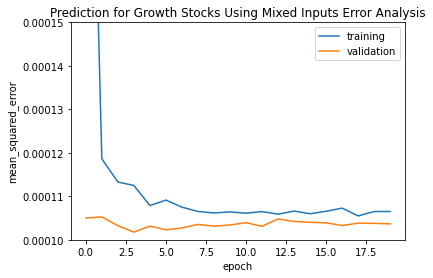

In [36]:
plt.plot(history.history["mean_squared_error"], label = "training")
plt.plot(history.history["val_mean_squared_error"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "mean_squared_error")
plt.title(label = "Prediction for Growth Stocks Using Mixed Inputs Error Analysis", loc = "center")
plt.ylim(0.0001, 0.00015)
plt.legend()

plt.savefig("growth_mixed_features.png")

In [37]:
# save the model
import pickle
filename = 'mixed_regression_growth.pkl'
pickle.dump(model, open(filename, 'wb'))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-08 15:20:16.046846: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ram://a142318f-e57a-49a5-bf62-51bf14c94b5e/assets


INFO:tensorflow:Assets written to: ram://a142318f-e57a-49a5-bf62-51bf14c94b5e/assets


### Running on Value Stocks

In [4]:
value_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "Treasury10yr_PercentChange": df[["Treasury10yr_PercentChange"]],
            "inflation5yr_PercentChange": df[["inflation5yr_PercentChange"]],
            "CPI_PercentChange"         : df[["CPI_PercentChange"]],
            "exchange_PercentChange"    : df[["exchange_PercentChange"]]
        },
        {
            "ValueStock_PercentChange" : df[["ValueStock_PercentChange"]]
        }
    )
)


# train, test split
train_size = int(0.7*(len(value_dataset)))
val_size = int(0.3*(len(value_dataset)))
train = value_dataset.take(train_size)
val   = value_dataset.skip(train_size).take(val_size)

# inputs
treasury_input = keras.Input(
    shape = (1,), 
    name = "Treasury10yr_PercentChange",
    dtype = "float64"
)

inflation_input = keras.Input(
    shape = (1,), 
    name = "inflation5yr_PercentChange",
    dtype = "float64"
)

CPI_input = keras.Input(
    shape = (1,), 
    name = "CPI_PercentChange",
    dtype = "float64"
)

exchange_input = keras.Input(
    shape = (1,), 
    name = "exchange_PercentChange",
    dtype = "float64"
)


# pipeline for treasury
treasury_features = Dense(300, activation='relu')(treasury_input)
treasury_features = Dense(300, activation='relu')(treasury_features)
treasury_features = Dropout(0.2)(treasury_features)
treasury_features = Dense(300, activation='relu')(treasury_features)

# pipeline for inflation
inflation_features = Dense(300, activation='relu')(inflation_input)
inflation_features = Dense(300, activation='relu')(inflation_features)
inflation_features = Dropout(0.2)(inflation_features)
inflation_features = Dense(300, activation='relu')(inflation_features)

# pipeline for CPI
CPI_features = Dense(300, activation='relu')(CPI_input)
CPI_features = Dense(300, activation='relu')(CPI_features)
CPI_features = Dropout(0.2)(CPI_features)
CPI_features = Dense(300, activation='relu')(CPI_features)

# pipeline for exchange rate
exchange_features = Dense(300, activation='relu')(exchange_input)
exchange_features = Dense(300, activation='relu')(exchange_features)
exchange_features = Dropout(0.2)(exchange_features)
exchange_features = Dense(300, activation='relu')(exchange_features)

# concatenation
main = layers.concatenate([treasury_features, inflation_features, CPI_features, exchange_features], axis = 1)

# output layer
main = layers.Dense(200, activation='relu')(main)
main = layers.Dense(200, activation='relu')(main)
output = layers.Dense(1, name = "ValueStock_PercentChange")(main)

# create the model
model2 = keras.Model(
    inputs = [treasury_input, inflation_input, CPI_input, exchange_input],
    outputs = output
)

model2.summary()

# specify loss function
model2.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

# train the model
history2 = model2.fit(train, 
                    validation_data=val,
                    epochs = 20)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Treasury10yr_PercentChange (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 inflation5yr_PercentChange (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 CPI_PercentChange (InputLayer)  [(None, 1)]         0           []                               
                                                                                              

2022-03-09 10:21:33.088223: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                                                  
 dense (Dense)                  (None, 300)          600         ['Treasury10yr_PercentChange[0][0
                                                                 ]']                              
                                                                                                  
 dense_3 (Dense)                (None, 300)          600         ['inflation5yr_PercentChange[0][0
                                                                 ]']                              
                                                                                                  
 dense_6 (Dense)                (None, 300)          600         ['CPI_PercentChange[0][0]']      
                                                                                                  
 dense_9 (Dense)                (None, 300)          600         ['exchange_PercentChange[0][0]'] 
          

2587/2587 [==============================] - 13s 5ms/step - loss: 1.2976e-04 - mean_squared_error: 1.2976e-04 - val_loss: 7.2280e-05 - val_mean_squared_error: 7.2280e-05
Epoch 9/20
2587/2587 [==============================] - 14s 5ms/step - loss: 1.2798e-04 - mean_squared_error: 1.2798e-04 - val_loss: 7.3149e-05 - val_mean_squared_error: 7.3149e-05
Epoch 10/20
2587/2587 [==============================] - 13s 5ms/step - loss: 1.2598e-04 - mean_squared_error: 1.2598e-04 - val_loss: 7.2691e-05 - val_mean_squared_error: 7.2691e-05
Epoch 11/20
2587/2587 [==============================] - 14s 6ms/step - loss: 1.2627e-04 - mean_squared_error: 1.2627e-04 - val_loss: 7.4832e-05 - val_mean_squared_error: 7.4832e-05
Epoch 12/20
2587/2587 [==============================] - 13s 5ms/step - loss: 1.2777e-04 - mean_squared_error: 1.2777e-04 - val_loss: 7.2989e-05 - val_mean_squared_error: 7.2989e-05
Epoch 13/20
2587/2587 [==============================] - 13s 5ms/step - loss: 1.2618e-04 - mean_squared

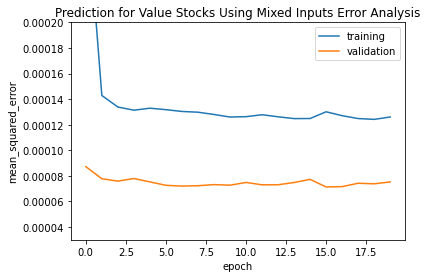

In [6]:
plt.plot(history2.history["mean_squared_error"], label = "training")
plt.plot(history2.history["val_mean_squared_error"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "mean_squared_error")
plt.title(label = "Prediction for Value Stocks Using Mixed Inputs Error Analysis", loc = "center")
plt.ylim(0.00003, 0.00020)
plt.legend()

plt.savefig("../images/value_mixed_features.png")

In [40]:
# save the model
filename = 'mixed_regression_value.pkl'
pickle.dump(model2, open(filename, 'wb'))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ram://1b6c043a-d9b4-4e84-9389-a197e3a7796c/assets


INFO:tensorflow:Assets written to: ram://1b6c043a-d9b4-4e84-9389-a197e3a7796c/assets


In [44]:
model2.save('mixed_regression_value')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: mixed_regression_value/assets


INFO:tensorflow:Assets written to: mixed_regression_value/assets


### Testing Dataset

In [73]:
# create test_data to pass to the model
test_data =  tf.data.Dataset.from_tensor_slices(
    (
        {
            "Treasury10yr_PercentChange": np.array([0.5]).reshape(-1,1),
            "inflation5yr_PercentChange": np.array([-0.5]).reshape(-1,1),
            "CPI_PercentChange"         : np.array([0.5]).reshape(-1,1),
            "exchange_PercentChange"    : np.array([0.5]).reshape(-1,1)
        }
    )
)

In [74]:
# make the prediction assuming it's a value stock
model2.predict(test_data)[0][0]

-0.00011632359